# Panoptic Segmentation Mock-up (Version 2)


Steps:
* Install + load dependencies
* Load test images
* Load pre-trained model
* Run inference on images
* Visualize output
* Extract inferences labels (From panoptic inferences)
* Save inference masks (From instance inferences)

Note: 
>Some of the code was taken from "Detectron2_Tutorial.ipynb". See "Detectron2_Tutorial_sandbox.ipynb" for loading different types of models and viewing different infences, as well as how to fine tune models.

>Original tutorial link(At bottom,lcick Colab Notebooks): https://detectron2.readthedocs.io/tutorials/getting_started.html

In [2]:
# install dependencies (Recommend from terminal): 
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions

# # install detectron2: (colab has CUDA 10.1 + torch 1.5)

# pip install pyyaml==5.1    #or => pip3 install pyyaml==5.1
# pip install pycocotools    #or => pip3 install pycocotools
# pip install opencv-python  #or => pip3 install opencv-python


# Load Dependencies:

In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.5.1 False
Configured with: --prefix=/Library/Developer/CommandLineTools/usr --with-gxx-include-dir=/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/4.2.1
Apple clang version 11.0.3 (clang-1103.0.32.62)
Target: x86_64-apple-darwin19.5.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


In [2]:
# assert torch.__version__.startswith("1.5")

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Load test Images:

In [5]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im1 = cv2.imread("./input.jpg")
im2 = cv2.imread("./beach.jpeg")
im3 = cv2.imread("./bikes.jpeg")

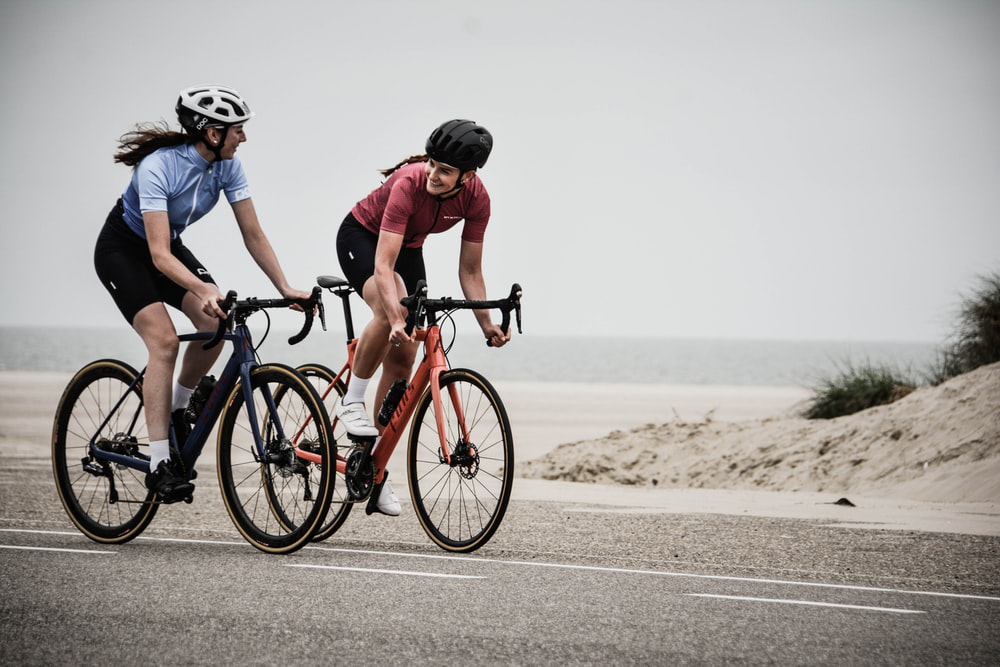

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
# Image.open("./input.jpg")
# Image.open("./beach.jpeg")
Image.open("./bikes.jpeg")

# LOAD PRE-TRAINED MODEL:

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

* Use cfg.MODEL.DEVICE='cpu' only if you don't have a GPU.

In [6]:
# NOTE: See for other models to use -> https://github.com/facebookresearch/detectron2/tree/master/configs

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))

# Anything inference has to be greater than 50%
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

# >>>run line below only if inference will be made on a CPU:
cfg.MODEL.DEVICE='cpu'

#run inference against predictor:
predictor = DefaultPredictor(cfg)

In [8]:
#----another option TO LOAD PRE-TRAINED MODEL---: 
# BUG: ***WARNING*** I think i still need to load the config before makign a prediction
#model = model_zoo.get("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml", trained=True)
# model.eval()
# with torch.no_grad():
#   outputs = model(im)

# Make predictions / inferences to image:

* Run input throught model to get an output

* Change any reference of im (options=> im1 | im2 | im3)
* Then change any reference of outputs (options=> outputs1 | outputs2 | outputs3) to corresponding  im

In [7]:
# guy in horse (from tutorial)
outputs1 = predictor(im1)

In [8]:
# beach
outputs2 = predictor(im2)

In [9]:
# girls cycling in beach
outputs3 = predictor(im3)

In [10]:
# select image to analyze:
im = im3 # options=> im1 | im2 | im3
outputs = outputs3 #options=> outputs1 | outputs2 | outputs

In [21]:
# look at the outputs:
#  -> NOTE:See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
# print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_masks)
print(outputs["panoptic_seg"][1])
#print(outputs["sem_seg"][:,:])

tensor([ 0,  0,  1,  1, 39])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., Fal

# Visualtize output:

* use `Visualizer` to draw the predictions on the image.

***WARNING*** After CV opens file on a separate windom, click on image, then press any key to continue, and do not close window if you want to run it again!!

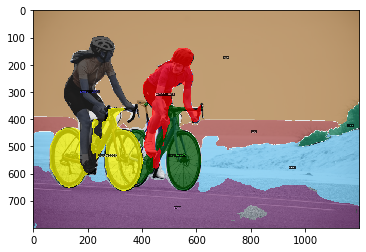

In [14]:
# -------Displays panoptic segmentation prediction results on an image-------
# NOTE: https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.visualizer.Visualizer.draw_panoptic_seg_predictions

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(outputs["panoptic_seg"][0], outputs["panoptic_seg"][1])
#cv2.imshow(out.get_image()[:, :, ::-1])
plt.imshow(out.get_image()[:, :, ::-1]) #small version

#im = cv2.imread(out.get_image()[:, :, ::-1])
cv2.imshow("output", out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

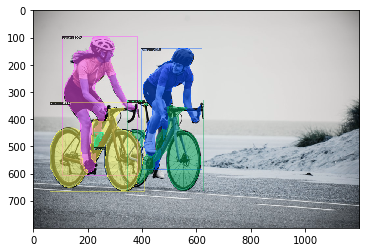

In [15]:
# -------Displays Instance prediction results on an image-------
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#cv2.imshow(out.get_image()[:, :, ::-1])
plt.imshow(out.get_image()[:, :, ::-1]) #too small

#im = cv2.imread(out.get_image()[:, :, ::-1])
cv2.imshow("output", out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

# Extract labels (Panoptic Segmentation Inference):

* Get the image labels from the panoptic segmentation prediction

In [18]:
# load classes
thing_classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

stuff_classes=['things', 'banner', 'blanket', 'bridge', 'cardboard', 'counter', 'curtain', 'door-stuff', 'floor-wood', 'flower', 'fruit', 'gravel', 'house', 'light', 'mirror-stuff', 'net', 'pillow', 'platform', 'playingfield', 'railroad', 'river', 'road', 'roof', 'sand', 'sea', 'shelf', 'snow', 'stairs', 'tent', 'towel', 'wall-brick', 'wall-stone', 'wall-tile', 'wall-wood', 'water', 'window-blind', 'window', 'tree', 'fence', 'ceiling', 'sky', 'cabinet', 'table', 'floor', 'pavement', 'mountain', 'grass', 'dirt', 'paper', 'food', 'building', 'rock', 'wall', 'rug']

In [27]:
#Get class ID (category_id) and the class it belongs to (bool)
classID = list()
for i in range(len(outputs["panoptic_seg"][1])):

    classID.append([outputs["panoptic_seg"][1][i]['category_id'], outputs["panoptic_seg"][1][i]['isthing']])
    print(outputs["panoptic_seg"][1][i])

print("")
print(classID)
print("")

{'id': 1, 'isthing': True, 'score': 0.999495267868042, 'category_id': 0, 'instance_id': 0, 'area': 34638.0}
{'id': 2, 'isthing': True, 'score': 0.9988834261894226, 'category_id': 0, 'instance_id': 1, 'area': 26726.0}
{'id': 3, 'isthing': True, 'score': 0.9974486231803894, 'category_id': 1, 'instance_id': 2, 'area': 38370.0}
{'id': 4, 'isthing': True, 'score': 0.9939423203468323, 'category_id': 1, 'instance_id': 3, 'area': 23873.0}
{'id': 5, 'isthing': False, 'category_id': 21, 'area': 122946.0}
{'id': 6, 'isthing': False, 'category_id': 23, 'area': 81396.0}
{'id': 7, 'isthing': False, 'category_id': 24, 'area': 34879.0}
{'id': 8, 'isthing': False, 'category_id': 37, 'area': 6769.0}
{'id': 9, 'isthing': False, 'category_id': 40, 'area': 281030.0}

[[0, True], [0, True], [1, True], [1, True], [21, False], [23, False], [24, False], [37, False], [40, False]]



In [51]:
# display labels extracted
# TODO: Labels might need to be a dictionary to be the corresponding value of an imageID key
labels_things= list()
labels_stuff = list()
for i in range(len(classID)):
    if classID[i][1] == True:
        # print(thing_classes[classID[i][0]])
        labels_things.append(thing_classes[classID[i][0]])
    else:
        # print(stuff_classes[classID[i][0]])
        labels_stuff.append(stuff_classes[classID[i][0]])

print(labels_things)
print(labels_stuff) # <--- we might only need the this result as input for the GAN models

['person', 'person', 'bicycle', 'bicycle']
['road', 'sand', 'sea', 'tree', 'sky']


# Save Masks (Instance segmentation):

* Get the masks from the Instance segmentation prediction
* We are using these masks because overlap which is what we need as inputs the GAN model

In [70]:
# convert Torch Tensors to a NumPy Arrays
# print(outputs["instances"].pred_classes.numpy())
# print(outputs["instances"].pred_masks.numpy())

# store numpy arrays in for mask class and mask
maskClass = outputs["instances"].pred_classes.numpy()
masksInferences =outputs["instances"].pred_masks.numpy()

In [55]:
#Get class ID (category_id) and the class it belongs to (bool)
maskClassID = list()
for i in range(len(maskClass)):
    # print(maskClass[i])
    maskClassID.append(maskClass[i])
    
print(maskClassID)

[0, 0, 1, 1, 39]


In [71]:
# display labels extracted
masksInferences
# TODO: might need to store as dictionaries and then convert to json maybe (depends on database)
maskInference_labels = list()
for i in range(len(maskClassID)):
    # print(thing_classes[maskClassID[i]])
    maskInference_labels.append(thing_classes[maskClassID[i]])

print(maskInference_labels) #notice how instance seg classified one/more things than the panoptic 

['person', 'person', 'bicycle', 'bicycle', 'bottle']


In [80]:
# TODO: Find out we will store the mask which is a multidimensial numpy array (Database???)
# print(len(masksInferences))
for i in range(0, len(masksInferences)):
    print("---------------------------")
    print("Label:", maskInference_labels[i])
    print(masksInferences[i])
    

---------------------------
Label: person
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
---------------------------
Label: person
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
---------------------------
Label: bicycle
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
---------------------------
Label: bicycle
[[False False False ... False False Fa